In [50]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from gensim.models import Word2Vec, Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from scipy.sparse import issparse
import matplotlib.pyplot as plt
from tabulate import tabulate
from sklearn.metrics import auc
import re
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve

In [20]:
# Ensure nltk resources are downloaded (if not already)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [25]:
class Preprocessing_Data:
    def __init__(self, filename):
        self.filename = filename
        self.data = pd.read_csv(self.filename)

    def preprocess(self):
        tokenizer = RegexpTokenizer(r'\w+')
        stop_words = set(stopwords.words('english'))
        stemmer = PorterStemmer()
        lemmatizer = WordNetLemmatizer()
        # Regular expressions for removing HTML tags, dates, and email addresses
        html_tag_pattern = r'<.*?>'
        date_pattern = r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b'
        email_pattern = r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b'

        def remove_patterns(text):
            text = re.sub(html_tag_pattern, '', text)  # Remove HTML tags
            text = re.sub(date_pattern, '', text)  # Remove dates
            text = re.sub(email_pattern, '', text)  # Remove email addresses
            return text

        self.data['processed_text'] = self.data['text'].apply(lambda x: ' '.join(
            lemmatizer.lemmatize(stemmer.stem(word))
            for word in tokenizer.tokenize(remove_patterns(x.lower()))
            if word not in stop_words and word.isalpha()
        ))
        return self.data[['processed_text', 'target']]

In [26]:
class POSTagger:
    def __init__(self):
        pass

    def pos_tagging(self, texts):
        tagged_texts = []
        for text in texts:
            tagged_text = nltk.pos_tag(nltk.word_tokenize(text))
            tagged_texts.append(tagged_text)
        return tagged_texts

In [27]:
class DataSplitter:
    def __init__(self, data, test_size=0.4, random_state=None, shuffle=True):
        self.data = data
        self.test_size = test_size
        self.random_state = random_state
        self.shuffle = shuffle

    def split_data(self):
        return train_test_split(self.data, test_size=self.test_size, random_state=self.random_state, shuffle=self.shuffle)

In [28]:
class TextEmbeddings:
    def __init__(self, texts, tokens):
        self.texts = texts
        self.tokens = tokens

    def create_bow(self):
        vectorizer = CountVectorizer()
        return vectorizer.fit_transform(self.texts)

    def create_tfidf(self):
        vectorizer = TfidfVectorizer()
        return vectorizer.fit_transform(self.texts)

    def create_word2vec(self):
        model = Word2Vec(self.tokens, vector_size=100, window=5, min_count=1, workers=4)
        return np.array([np.mean([model.wv[word] for word in text if word in model.wv] or [np.zeros(100)], axis=0) for text in self.tokens])

    def create_doc2vec(self):
        tagged_data = [TaggedDocument(words=text, tags=[str(i)]) for i, text in enumerate(self.tokens)]
        model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4, epochs=20)
        return np.array([model.dv[str(i)] for i in range(len(tagged_data))])

In [36]:
class ModelTraining:
    def __init__(self, X, y, test_size=0.4, random_state=42, shuffle=True):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.random_state = random_state
        self.shuffle = shuffle

    def train_logistic_regression(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state, shuffle=self.shuffle)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train, y_train)
        return model, X_test, y_test

    def train_decision_tree(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size, random_state=self.random_state, shuffle=self.shuffle)
        model = DecisionTreeClassifier()
        model.fit(X_train, y_train)
        return model, X_test, y_test

In [32]:
class ModelEvaluator:
    def __init__(self, model, X_test, y_test):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test

    def evaluate_model(self):
        y_pred = self.model.predict(self.X_test)
        return {
            "Accuracy": accuracy_score(self.y_test, y_pred),
            "Precision": precision_score(self.y_test, y_pred, average='macro'),
            "Recall": recall_score(self.y_test, y_pred, average='macro'),
            "F1-Score": f1_score(self.y_test, y_pred, average='macro')
        }


def output_results_comparison(results):
    # Extract metrics for each model
    metrics = {}
    for model_name, model_result in results.items():
        metrics[model_name] = ModelEvaluator(*model_result).evaluate_model()

    # Plot comparisons
    plt.figure(figsize=(12, 8))

    for i, metric in enumerate(metrics.values()):
        plt.subplot(2, 2, i+1)
        plt.bar(range(len(metric)), list(metric.values()), align='center')
        plt.xticks(range(len(metric)), list(metric.keys()), rotation=45)
        plt.title(list(metrics.keys())[i] + ' Comparison')

    plt.tight_layout()
    plt.show()

In [29]:
preprocessing = Preprocessing_Data('Spam_Email_Data.csv')
processed_data = preprocessing.preprocess()
# Output the first few rows of the processed data
print(processed_data.head())

                                      processed_text  target
0  mon jul return path deliv receiv localhost loc...       0
1  mon jun return path deliveri date tue jun rece...       1
2  mon jul return path deliv receiv localhost loc...       1
3  mon jun return path deliveri date mon jun rece...       1
4  mon aug return path deliv receiv localhost loc...       0


In [30]:
 # POS tagging
pos_tagger = POSTagger()
tagged_texts = pos_tagger.pos_tagging(processed_data['processed_text'])

In [62]:
# Output the tagged texts for the first few rows
num_rows_to_display = 1

for i, tagged_text in enumerate(tagged_texts[:num_rows_to_display]):
    print(f"Text {i+1}:")
    for word, pos_tag in tagged_text:
        print(f"Word: {word}, POS Tag: {pos_tag}")
    print()


Text 1:
Word: mon, POS Tag: NN
Word: jul, POS Tag: NN
Word: return, POS Tag: VBP
Word: path, POS Tag: NN
Word: deliv, POS Tag: NN
Word: receiv, POS Tag: NN
Word: localhost, POS Tag: NN
Word: localhost, POS Tag: NN
Word: phobo, POS Tag: NN
Word: lab, POS Tag: NN
Word: netnoteinc, POS Tag: NN
Word: com, POS Tag: NN
Word: postfix, POS Tag: NN
Word: esmtp, POS Tag: NN
Word: id, POS Tag: NN
Word: mon, POS Tag: NN
Word: jul, POS Tag: NN
Word: edt, POS Tag: VBP
Word: receiv, POS Tag: NN
Word: phobo, POS Tag: NN
Word: localhost, POS Tag: NN
Word: imap, POS Tag: JJ
Word: fetchmail, POS Tag: NN
Word: jm, POS Tag: NN
Word: localhost, POS Tag: NN
Word: singl, POS Tag: JJ
Word: drop, POS Tag: NN
Word: mon, POS Tag: NN
Word: jul, POS Tag: NN
Word: ist, POS Tag: NN
Word: receiv, POS Tag: NN
Word: lugh, POS Tag: IN
Word: tuatha, POS Tag: NN
Word: org, POS Tag: JJ
Word: dogma, POS Tag: NN
Word: slashnul, POS Tag: NN
Word: org, POS Tag: JJ
Word: esmtp, POS Tag: NN
Word: id, POS Tag: NN
Word: sat, POS Ta

In [34]:
# Generate text embeddings
tokens = processed_data['processed_text'].apply(lambda x: x.split())  # Convert processed text into tokens
embeddings = TextEmbeddings(processed_data['processed_text'], tokens)

bow = embeddings.create_bow()
tfidf = embeddings.create_tfidf()
word2vec = embeddings.create_word2vec()
doc2vec = embeddings.create_doc2vec()
labels = processed_data['target']
embedding_types = {'BOW': bow, 'TF-IDF': tfidf, 'Word2Vec': word2vec, 'Doc2Vec': doc2vec}
results = {}

In [39]:
# Train models and evaluate
for emb_name, emb_data in embedding_types.items():
    model_training = ModelTraining(emb_data, labels)

    # Logistic Regression
    model_lr, X_test_lr, y_test_lr = model_training.train_logistic_regression()
    evaluator_lr = ModelEvaluator(model_lr, X_test_lr, y_test_lr)
    results[f'Logistic Regression {emb_name}'] = evaluator_lr.evaluate_model()

    # Decision Tree
    model_dt, X_test_dt, y_test_dt = model_training.train_decision_tree()
    evaluator_dt = ModelEvaluator(model_dt, X_test_dt, y_test_dt)
    results[f'Decision Tree {emb_name}'] = evaluator_dt.evaluate_model()

In [41]:
# Print results in tabular format
headers = ["Model", "Accuracy", "Precision", "Recall", "F1-Score"]
table_data = []
for result_name, metrics in results.items():
    # Convert metrics to numerical values if they are stored as strings
    metrics = {k: float(v) if isinstance(v, str) else v for k, v in metrics.items()}

    # Round numerical metrics to 4 decimal places
    rounded_metrics = {k: round(v, 4) for k, v in metrics.items()}

    # Append model name and rounded metrics to table data
    table_data.append([result_name] + list(rounded_metrics.values()))

print(tabulate(table_data, headers=headers, tablefmt="grid"))


+------------------------------+------------+-------------+----------+------------+
| Model                        |   Accuracy |   Precision |   Recall |   F1-Score |
+==============================+============+=============+==========+============+
| Logistic Regression BOW      |     0.9957 |      0.9961 |   0.994  |     0.9951 |
+------------------------------+------------+-------------+----------+------------+
| Decision Tree BOW            |     0.9728 |      0.971  |   0.9667 |     0.9688 |
+------------------------------+------------+-------------+----------+------------+
| Logistic Regression TF-IDF   |     0.9832 |      0.9867 |   0.975  |     0.9806 |
+------------------------------+------------+-------------+----------+------------+
| Decision Tree TF-IDF         |     0.9685 |      0.9625 |   0.9659 |     0.9642 |
+------------------------------+------------+-------------+----------+------------+
| Logistic Regression Word2Vec |     0.9875 |      0.989  |   0.9824 |     0

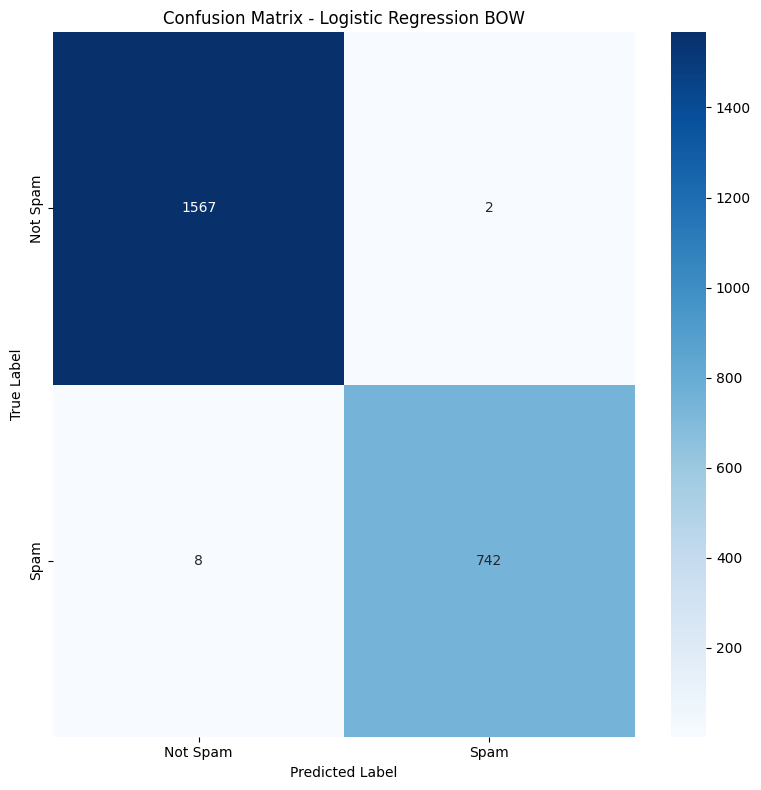

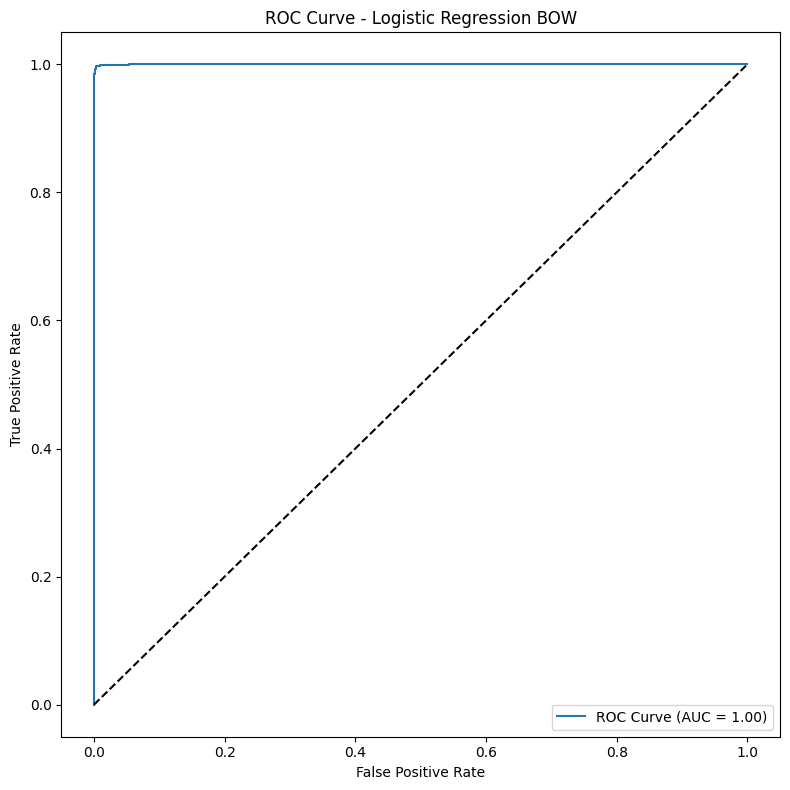

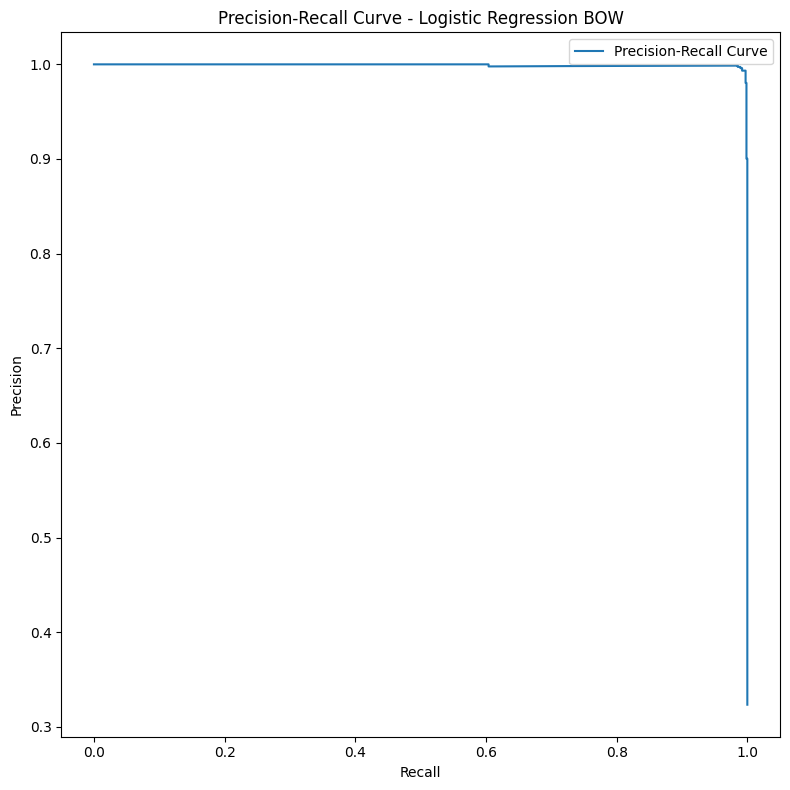

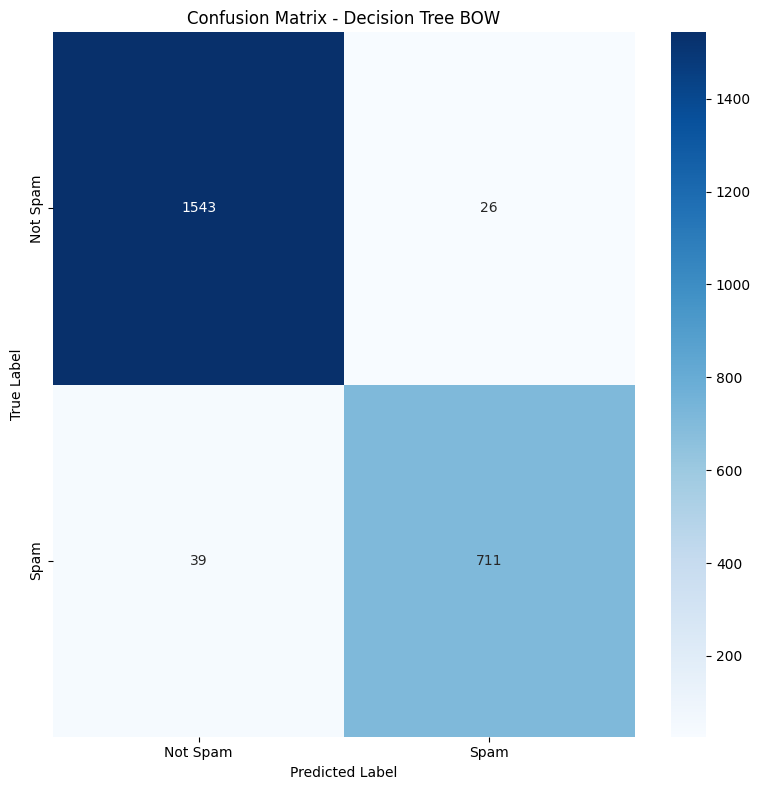

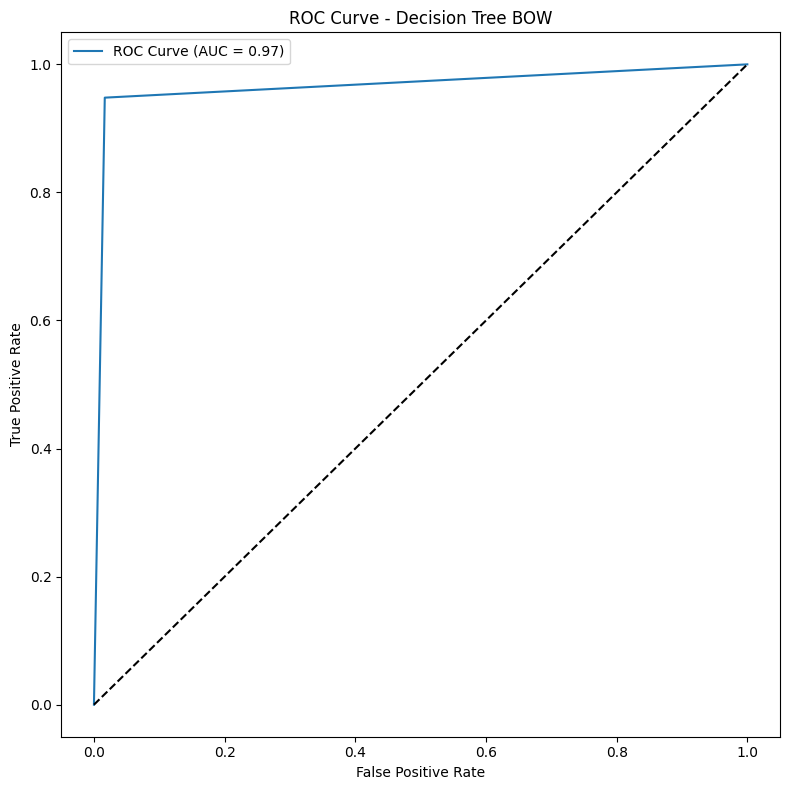

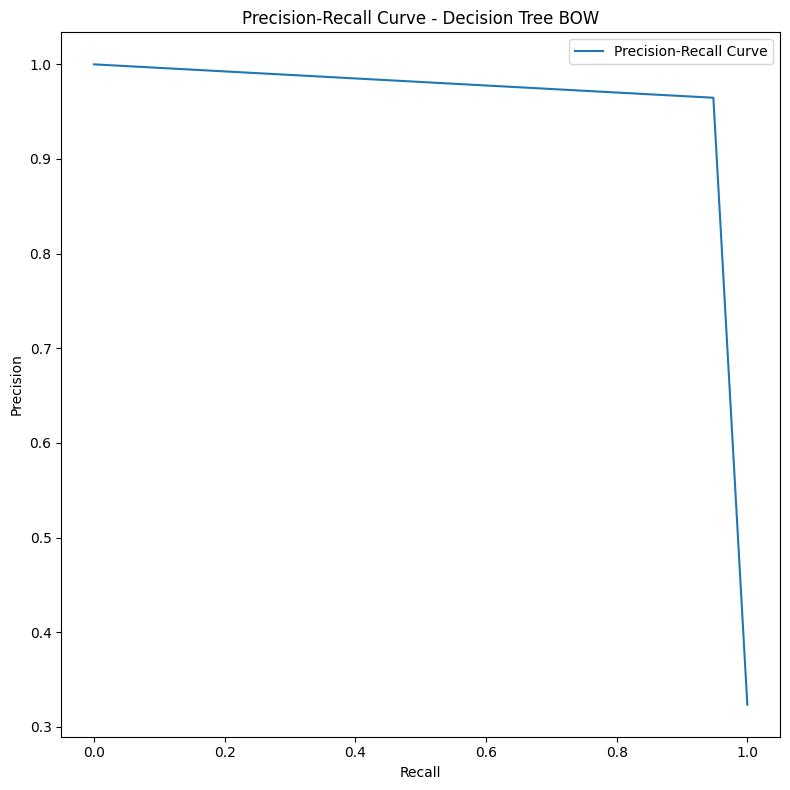

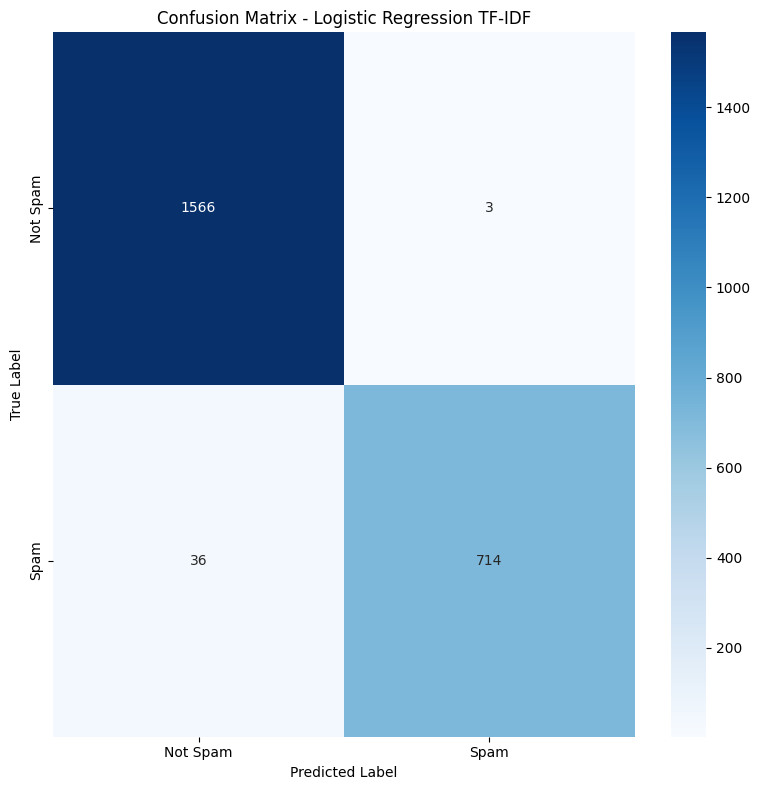

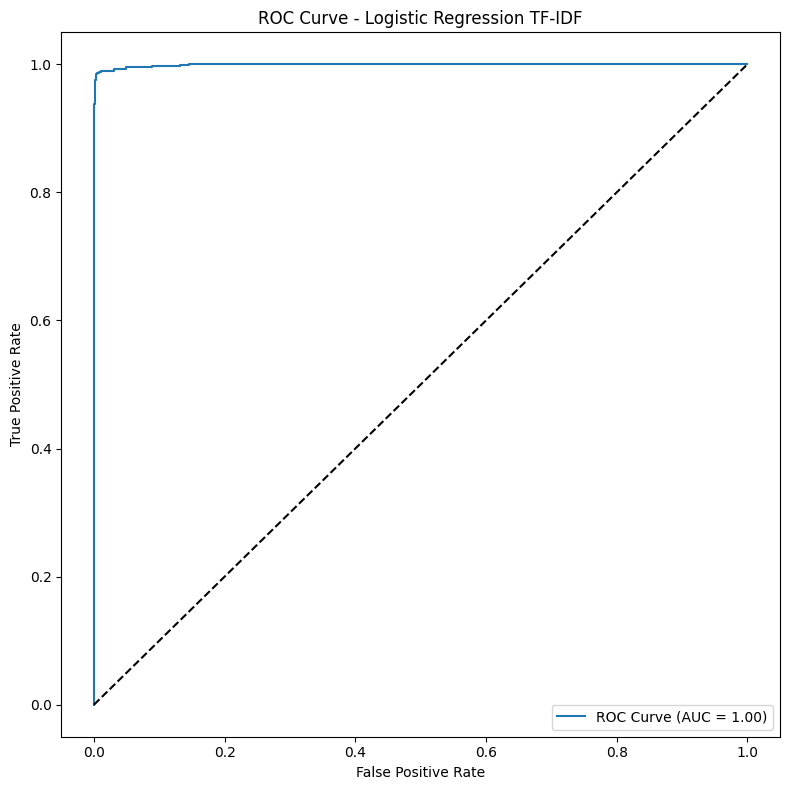

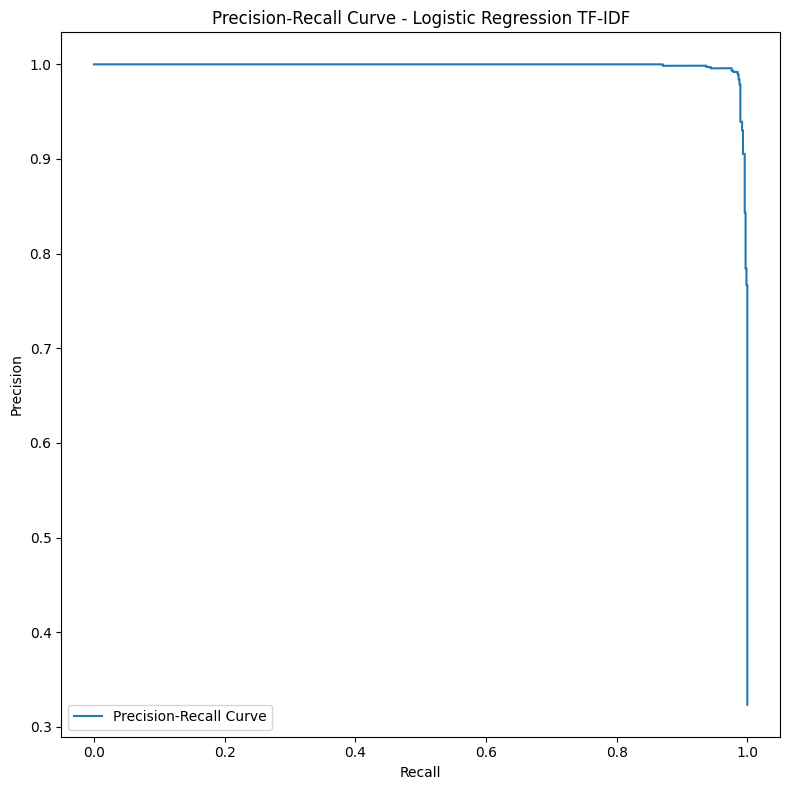

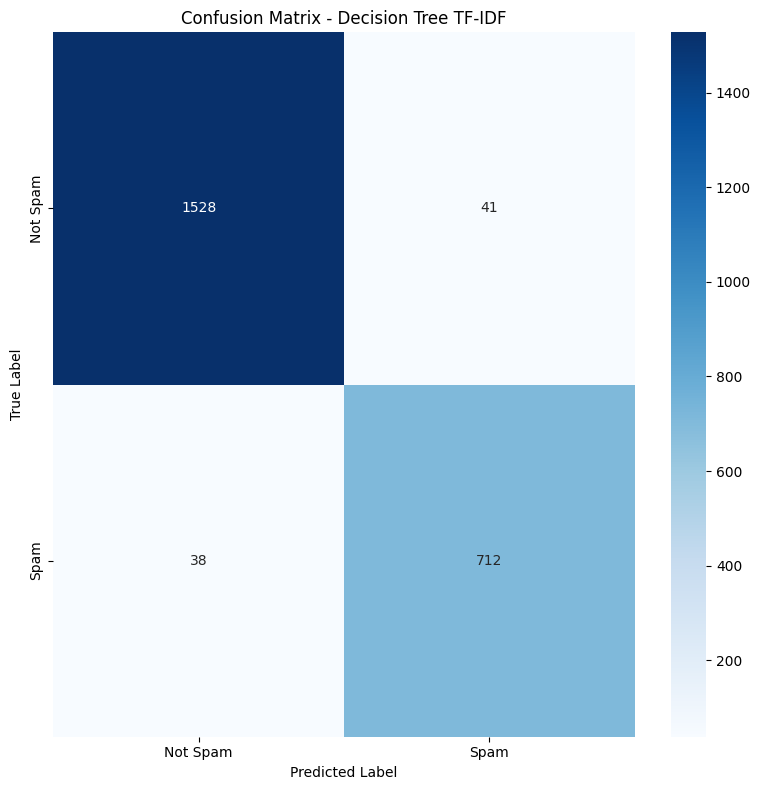

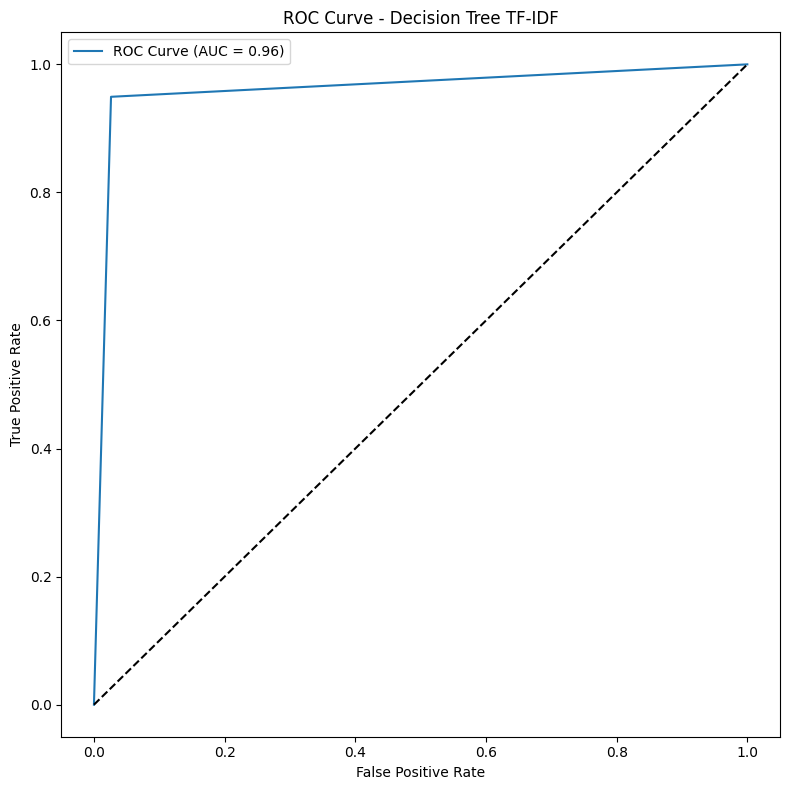

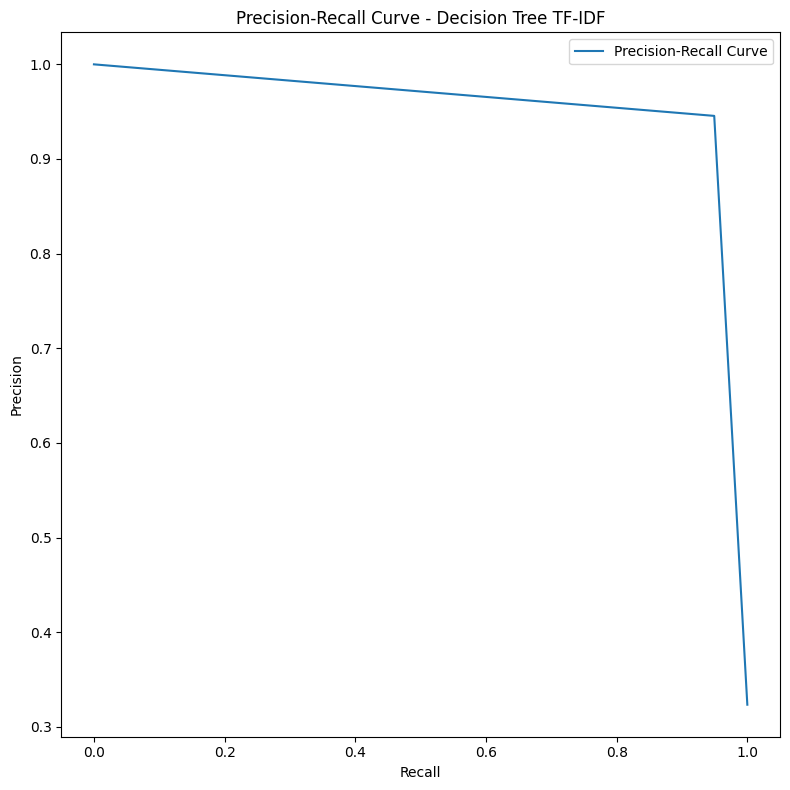

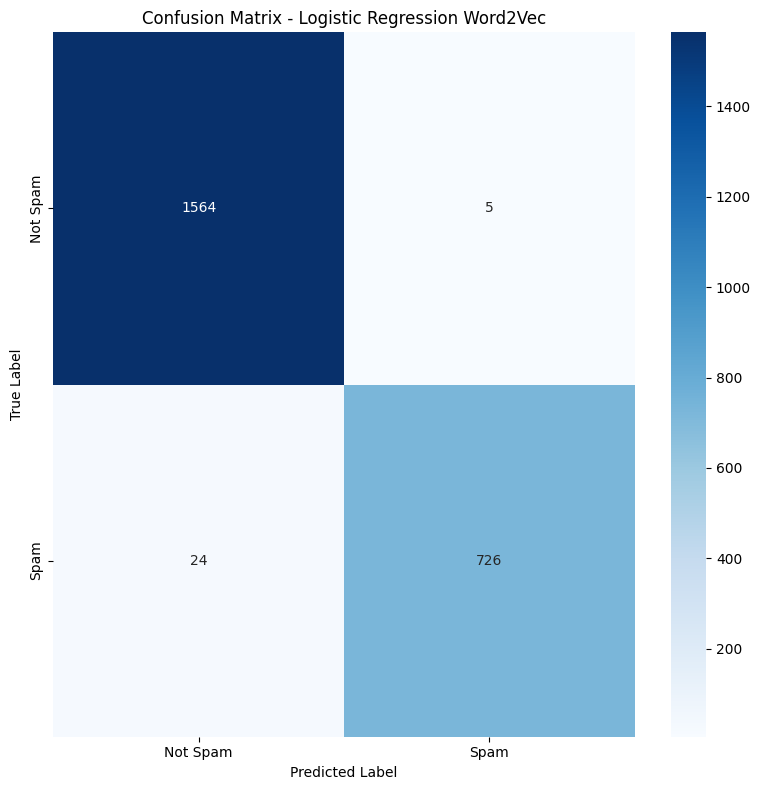

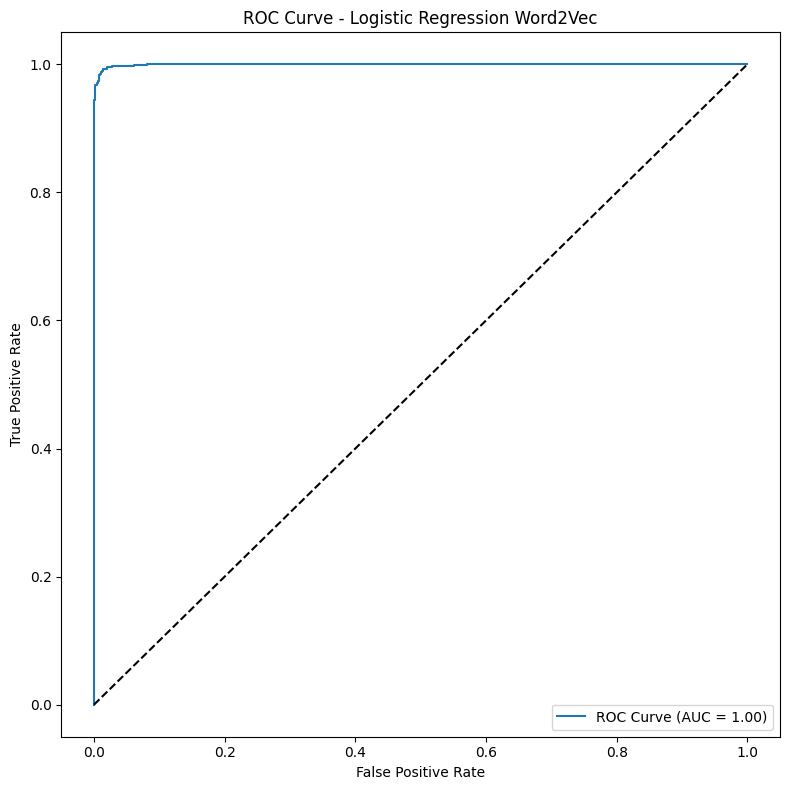

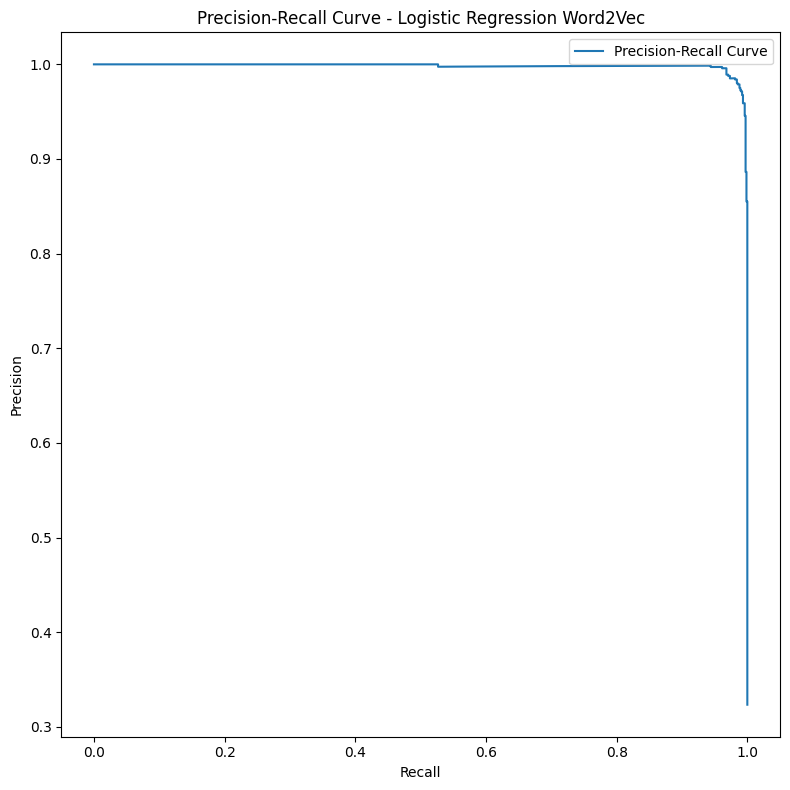

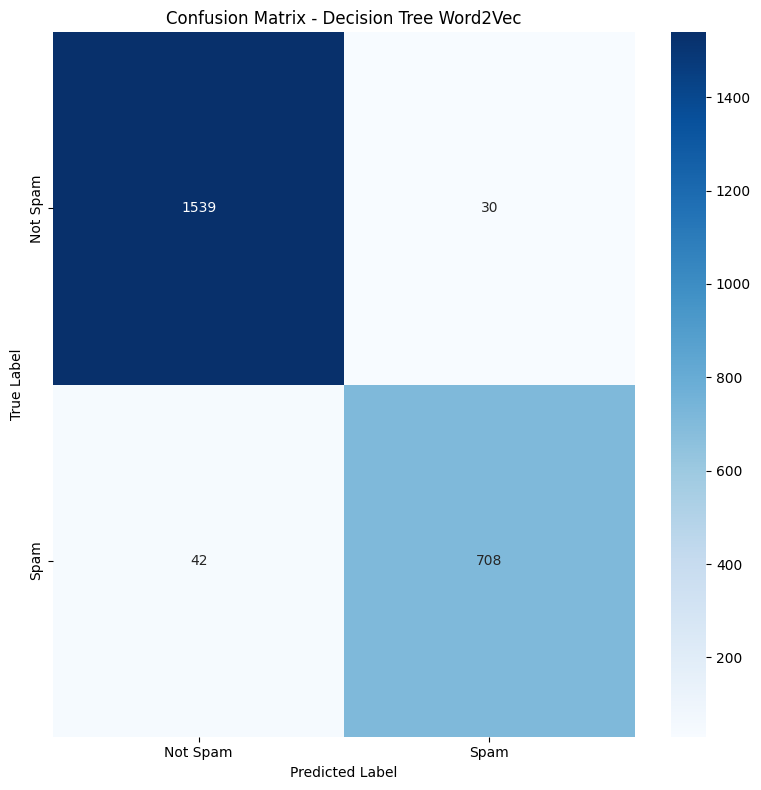

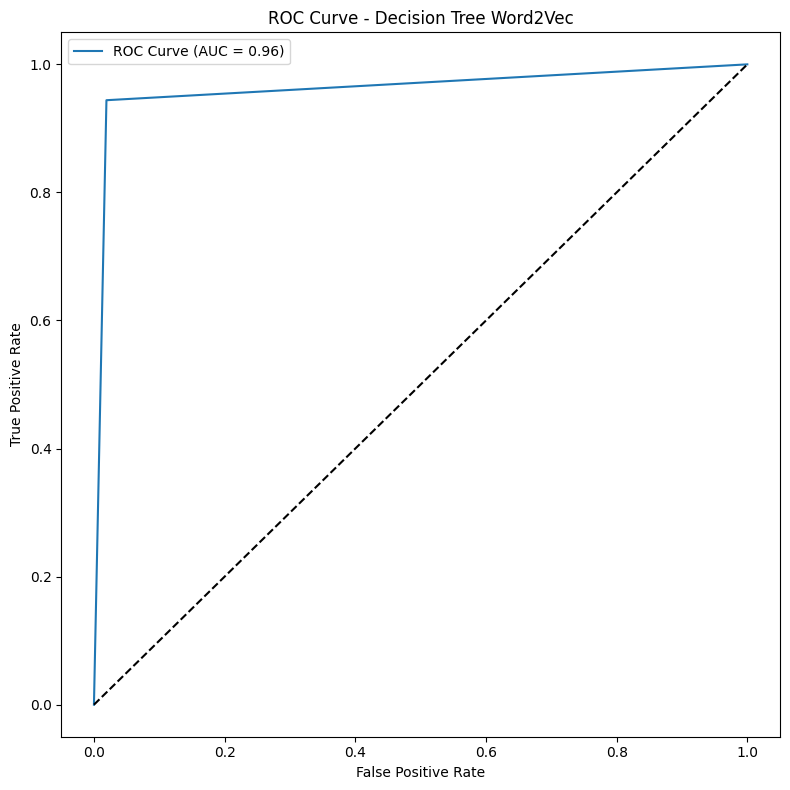

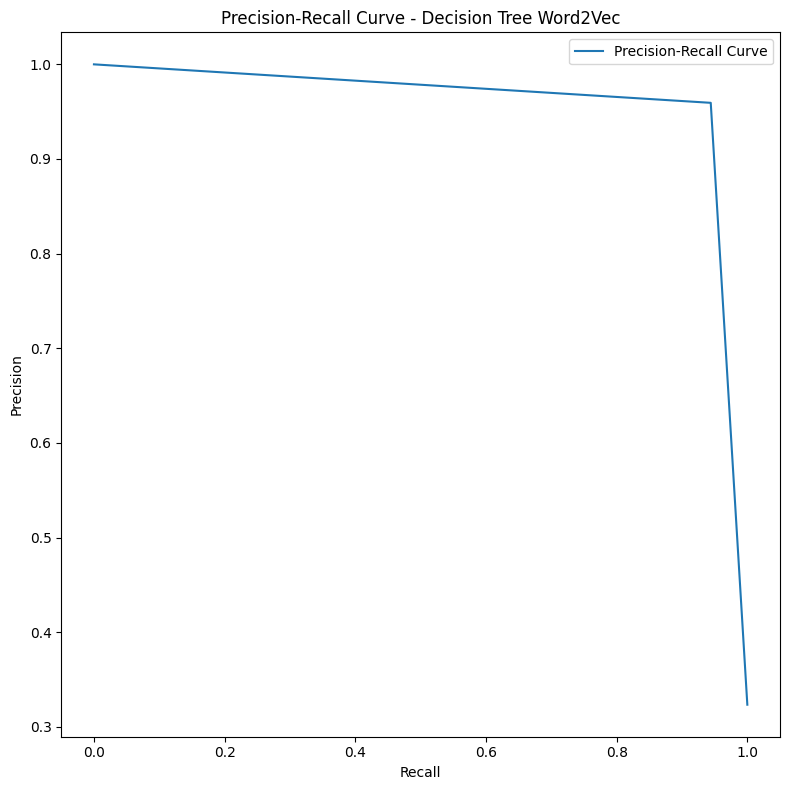

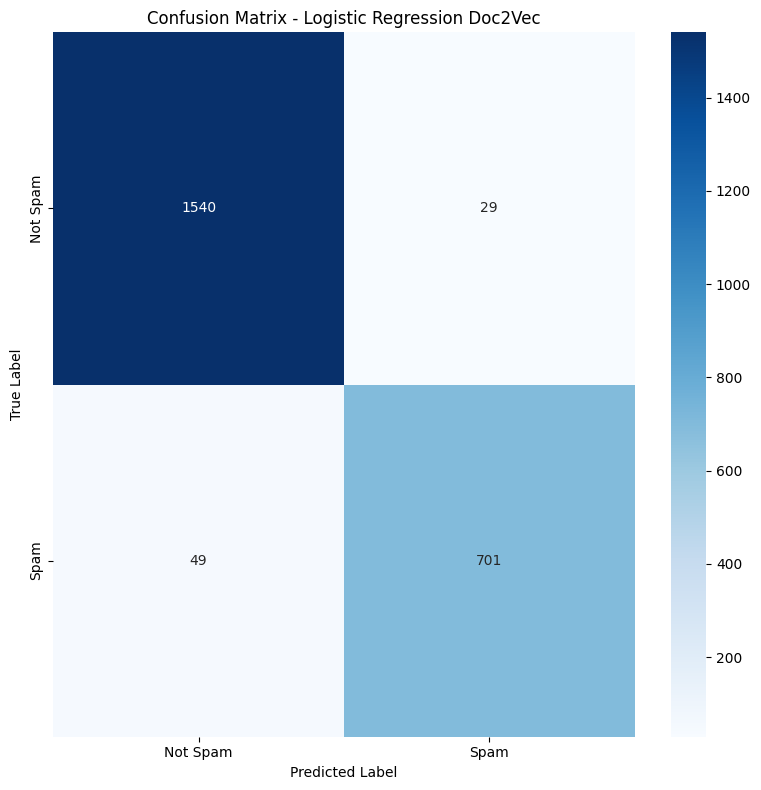

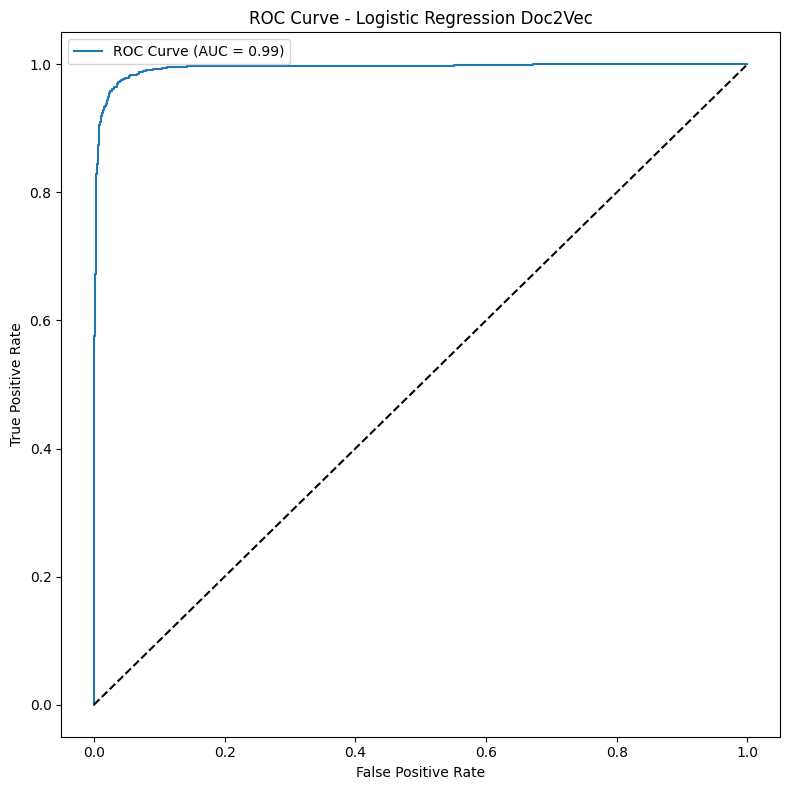

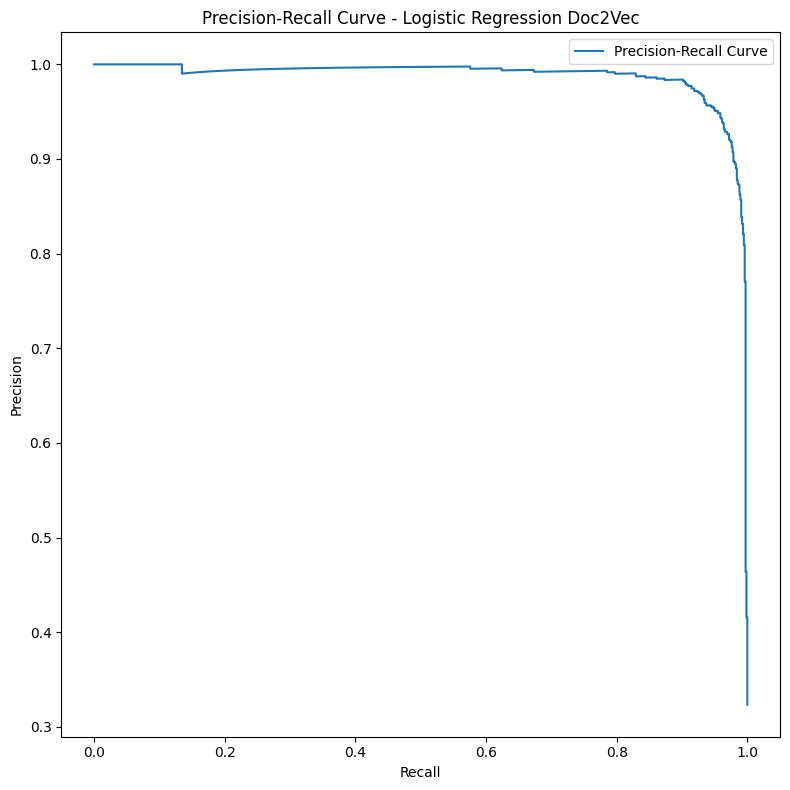

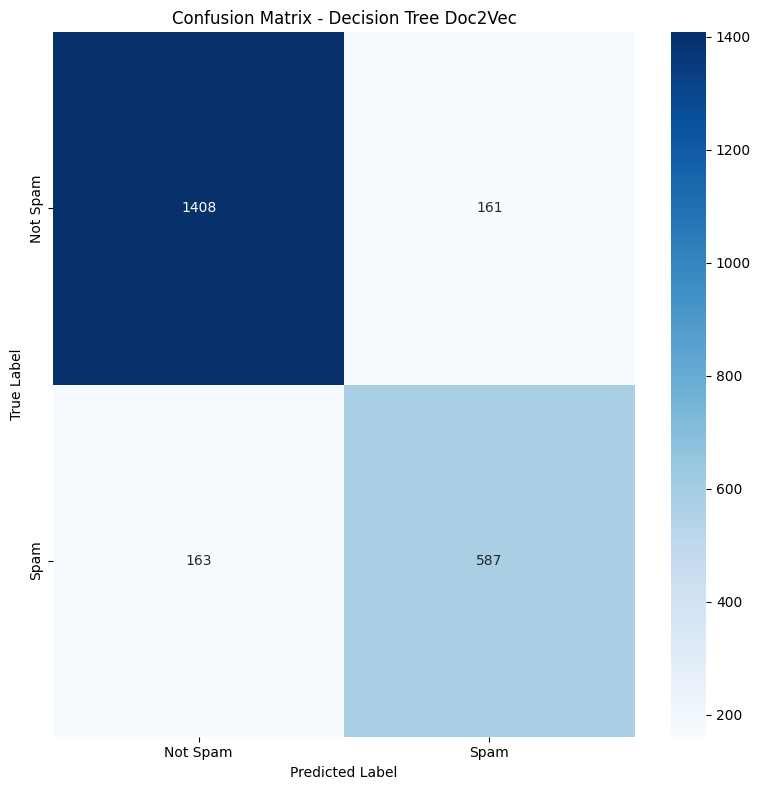

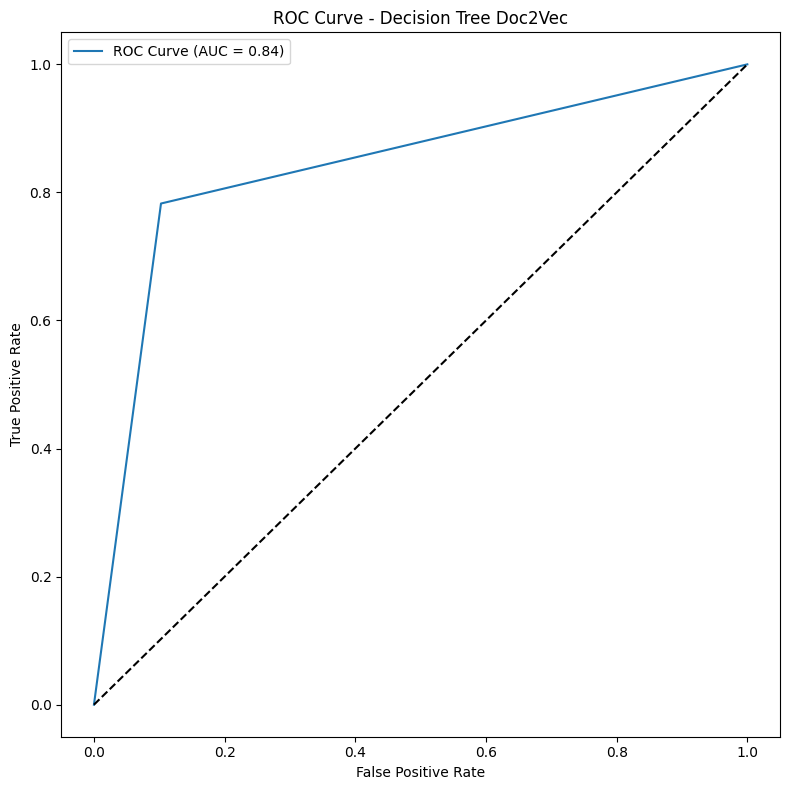

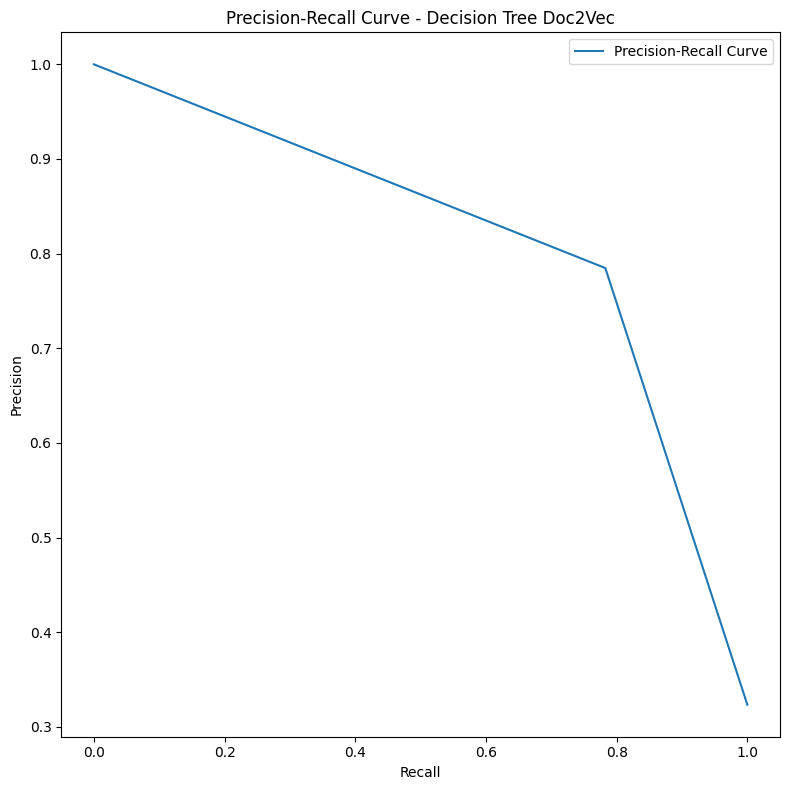

In [61]:
# Generate visualizations and reports for each model
for model_name, (model, X_test, y_test) in models.items():
    # Confusion Matrix
    y_pred = model.predict(X_test)
    plot_confusion_matrix(y_test, y_pred, model_name)

    # ROC Curve
    y_pred_proba = model.predict_proba(X_test)
    plot_roc_curve(y_test, y_pred_proba, model_name)

    # Precision-Recall Curve
    plot_precision_recall_curve(y_test, y_pred_proba, model_name)